In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

2023-06-01 01:10:35.345267: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 01:10:35.387960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 01:10:35.388505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 01:10:36.046188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#ここまでnamesを使ってきたが、namesは名前を指定するだけで間違いだということが分かった
#使いたい列を選んで取ってくるのはusecols

# 元データの必要な特徴量が記録されている列番号.以下の説明変数が下の番号に対応してる
'''m_speed_stddev_480
m_acceleration_stddev_480
m_jerk_stddev_480
m_steering_stddev_480
AccelInput_stddev_480
BrakeInput_stddev_480
realtime steering entropy_1100
realtime steering entropy_1100_stddev_480
perclos'''
#24, 25は目的変数
cols = [3,6,9,12,15,18,19,21,22,24,25]

# 1つ目の訓練データの読み込み
data_path = './dms_data/'
train_data_1 = data_path + 'train/20201126_1546_0_y_train.csv'
train1 = pd.read_csv(train_data_1,usecols=cols)

# 2つ目の訓練データの読み込み
train_data_2 = data_path + 'train/20201127_1432_7_y_train.csv'
train2 = pd.read_csv(train_data_2,usecols=cols)

# テストデータの読み込み
test_data_1 = data_path + 'test/20201126_1546_0_y_test.csv'
test1 = pd.read_csv(test_data_1,usecols=cols)

# ファイルの連結
train = pd.concat([train1,train2])

# Pandasのデータフレームを作成
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test1)

# 欠損値の削除とインデックスの再設定
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#変換しなくてもfloat型で読み込めてる。恐らく1行目の変数を読み込んでいないから？


In [3]:
train.info()
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 0 to 140
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   m_speed_stddev_480                         217 non-null    float64
 1   m_acceleration_stddev_480                  217 non-null    float64
 2   m_jerk_stddev_480                          217 non-null    float64
 3   m_steering_stddev_480                      217 non-null    float64
 4   AccelInput_stddev_480                      217 non-null    float64
 5   BrakeInput_stddev_480                      217 non-null    float64
 6   realtime steering entropy_1100             265 non-null    float64
 7   realtime steering entropy_1100_stddev_480  217 non-null    float64
 8   perclos                                    265 non-null    float64
 9   oss                                        285 non-null    float64
 10  Sleepiness                     

,m_speed_stddev_480,m_acceleration_stddev_480,m_jerk_stddev_480,m_steering_stddev_480,AccelInput_stddev_480,BrakeInput_stddev_480,realtime steering entropy_1100,realtime steering entropy_1100_stddev_480,perclos,oss,Sleepiness
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,265.000000,217.000000,265.000000,285.000000,283.000000
mean,8.821958,0.073389,0.004324,0.009926,0.172456,0.006408,0.006701,0.005112,0.393212,2.515429,4.265015
std,2.896824,0.021646,0.001587,0.003587,0.045315,0.009354,0.011025,0.005222,0.173642,0.545668,1.567952
min,4.191864,0.030591,0.001345,0.004913,0.071054,0.000000,0.000000,0.000056,0.071826,1.000000,2.000000
25%,6.189240,0.059185,0.003428,0.006833,0.140722,0.000000,0.000000,0.000935,0.238864,2.264717,3.000000
50%,9.286268,0.077536,0.004411,0.008279,0.183987,0.000000,0.002705,0.002694,0.387222,2.471206,4.000000
75%,10.870346,0.091588,0.004824,0.013836,0.209113,0.013315,0.007346,0.007627,0.534483,2.931673,5.000000
max,16.134501,0.107539,0.007949,0.015928,0.238906,0.030427,0.068660,0.021006,0.871309,4.000000,8.000000


In [4]:
train.head()
train.tail()

,m_speed_stddev_480,m_acceleration_stddev_480,m_jerk_stddev_480,m_steering_stddev_480,AccelInput_stddev_480,BrakeInput_stddev_480,realtime steering entropy_1100,realtime steering entropy_1100_stddev_480,perclos,oss,Sleepiness
136,12.776700,0.083995,0.003348,0.014946,0.215738,0.0,0.004066,0.006277,0.407697,3.333333,8.0
137,12.710057,0.083661,0.003334,0.014512,0.214356,0.0,0.003944,0.006185,0.306793,3.196323,8.0
138,12.573110,0.083439,0.003327,0.014416,0.214605,0.0,0.004410,0.004516,0.261958,2.872115,8.0
139,12.788816,0.084284,0.003282,0.014491,0.216364,0.0,0.003046,0.003691,0.320534,2.999574,8.0
140,12.727398,0.083902,0.003299,0.014324,0.215464,0.0,0.002920,0.003608,0.415599,3.265055,8.0


In [5]:
print(train.shape)
print(train.columns)

(285, 11)
Index(['m_speed_stddev_480', 'm_acceleration_stddev_480', 'm_jerk_stddev_480',
       'm_steering_stddev_480', 'AccelInput_stddev_480',
       'BrakeInput_stddev_480', 'realtime steering entropy_1100',
       'realtime steering entropy_1100_stddev_480', 'perclos', 'oss',
       'Sleepiness'],
      dtype='object')


In [6]:
# 説明変数が1変数の場合が以下の通りになる。
# 1変数の場合はdf_trainから1つだけ読み込む。

# 説明変数,目的変数の設定
# 訓練データ
X_train = df_train['perclos'].values # 説明変数
X_train = X_train.reshape(-1,1) # 2次元配列に変換
y_train = df_train['Sleepiness'].values # 目的変数
y_train = y_train.reshape(-1,1) # 2次元配列に変換

# テストデータ
X_test = df_test['perclos'].values # 説明変数
X_test = X_test.reshape(-1,1) # 2次元配列に変換
y_test = df_test['Sleepiness'].values # 目的変数
y_test = y_test.reshape(-1,1) # 2次元配列に変換
#2変数以上の場合は必要ない変数を落とす.dropを使う

# 説明変数,目的変数
X_train = df_train.drop(['oss', 'Sleepiness'],axis=1).values #axis=1で列
y_train = df_train['oss'].values # 目的変数
print(X_train.shape)

X_test = df_test.drop(['oss', 'Sleepiness'],axis=1).values # 説明変数
y_test = df_test['oss'].values # 目的変数

(217, 9)


In [7]:
# モデルの学習
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train,y_train) # モデルの学習

# テストデータの予測
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1,1)

print(y_pred.shape)

(36, 1)


##### すべてのtrain,testを結合して学習は、別ファイルで実行済。

In [8]:
# モデルの学習
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train,y_train) # 訓練データでモデルの学習

# テストデータの予測
y_pred = model.predict(X_test) #テスト用データで予測値を出す。
print(y_pred.shape)
print(y_test.shape)

# モデル評価
# 正解率は分類でしか測れないためない。先輩のは間違い

# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

(36,)
(36,)
RMSE : 0.7387389438647483


In [9]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def read_and_process(file):
  df = pd.read_csv(file)
  df = df.drop(['timestamp'], axis=1)
  df = df.dropna()
  return df


def train_model(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42)
  train_data = lgb.Dataset(X_train, label=y_train)
  eval_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
  params = {
      'objective': 'regression',
      'metric': 'rmse',
      'verbose': -1
  }
  model = lgb.train(params, train_data, valid_sets=eval_data)
  return model, X_test, y_test


def normalize_data(series):
  scaler = MinMaxScaler()
  series = series.values.reshape(-1, 1)
  series = scaler.fit_transform(series)
  series = series.ravel()
  return pd.Series(series)

In [10]:
train_data_path = './dms_data/train'
files = os.listdir(train_data_path)

df_list = []
for file in files:
  if file.endswith('.csv'):
    df = read_and_process(os.path.join(train_data_path, file))
    df_list.append(df)

train_df = pd.concat(df_list, ignore_index=True)

X_oss = train_df.drop(['oss', 'Sleepiness'], axis=1)
y_oss = train_df['oss']

X_sleepiness = train_df.drop(['oss', 'Sleepiness'], axis=1)
y_sleepiness = train_df['Sleepiness']

y_oss = normalize_data(y_oss)
y_sleepiness = normalize_data(y_sleepiness)

In [11]:
model_oss, X_test_oss, y_test_oss = train_model(X_oss, y_oss)

model_sleepiness, X_test_sleepiness, y_test_sleepiness = train_model(X_sleepiness, y_sleepiness)


[1]	valid_0's rmse: 0.205158
[2]	valid_0's rmse: 0.191345
[3]	valid_0's rmse: 0.179731
[4]	valid_0's rmse: 0.16975
[5]	valid_0's rmse: 0.161701
[6]	valid_0's rmse: 0.154361
[7]	valid_0's rmse: 0.147152
[8]	valid_0's rmse: 0.141038
[9]	valid_0's rmse: 0.136452
[10]	valid_0's rmse: 0.132449
[11]	valid_0's rmse: 0.129289
[12]	valid_0's rmse: 0.126064
[13]	valid_0's rmse: 0.123026
[14]	valid_0's rmse: 0.121193
[15]	valid_0's rmse: 0.119088
[16]	valid_0's rmse: 0.117599
[17]	valid_0's rmse: 0.115588
[18]	valid_0's rmse: 0.114731
[19]	valid_0's rmse: 0.1129
[20]	valid_0's rmse: 0.11167
[21]	valid_0's rmse: 0.110951
[22]	valid_0's rmse: 0.109728
[23]	valid_0's rmse: 0.109035
[24]	valid_0's rmse: 0.108452
[25]	valid_0's rmse: 0.10756
[26]	valid_0's rmse: 0.106843
[27]	valid_0's rmse: 0.106037
[28]	valid_0's rmse: 0.105461
[29]	valid_0's rmse: 0.104787
[30]	valid_0's rmse: 0.104753
[31]	valid_0's rmse: 0.104229
[32]	valid_0's rmse: 0.104028
[33]	valid_0's rmse: 0.103023
[34]	valid_0's rmse: 0.1

In [12]:
test_data_path = './dms_data/test'
files = os.listdir(test_data_path)

df_list = []
for file in files:
  if file.endswith('.csv'):
    df = read_and_process(os.path.join(test_data_path, file))
    df_list.append(df)

test_df = pd.concat(df_list, ignore_index=True)

X_test_oss = test_df.drop(['oss', 'Sleepiness'], axis=1)
y_test_oss = test_df['oss']

X_test_sleepiness = test_df.drop(['oss', 'Sleepiness'], axis=1)
y_test_sleepiness = test_df['Sleepiness']

y_test_oss = normalize_data(y_test_oss)
y_test_sleepiness = normalize_data(y_test_sleepiness)

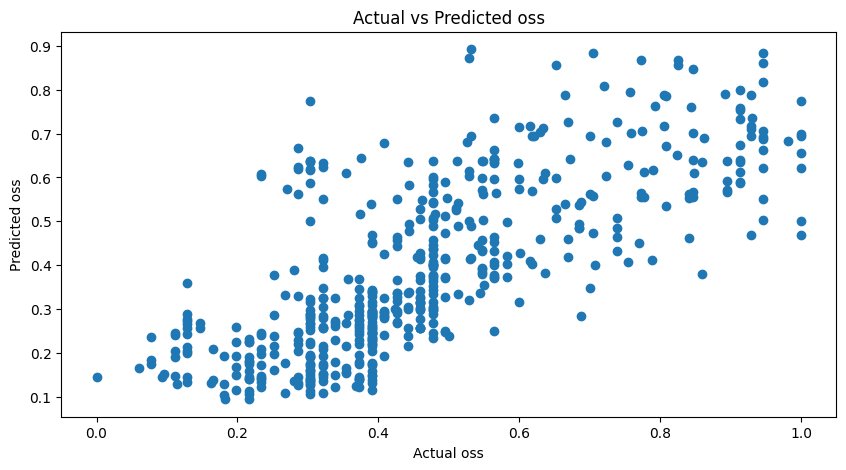

In [13]:
oss_preds = model_oss.predict(X_test_oss)
plt.figure(figsize=(10, 5))
plt.scatter(y_test_oss, oss_preds)
plt.xlabel('Actual oss')
plt.ylabel('Predicted oss')
plt.title('Actual vs Predicted oss')
plt.show()

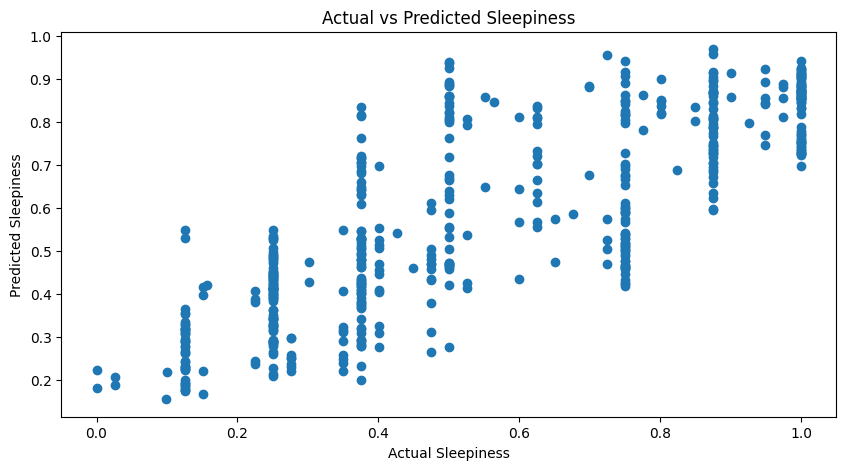

In [14]:
sleepiness_preds = model_sleepiness.predict(X_test_sleepiness)
plt.figure(figsize=(10, 5))
plt.scatter(y_test_sleepiness, sleepiness_preds)
plt.xlabel('Actual Sleepiness')
plt.ylabel('Predicted Sleepiness')
plt.title('Actual vs Predicted Sleepiness')
plt.show()

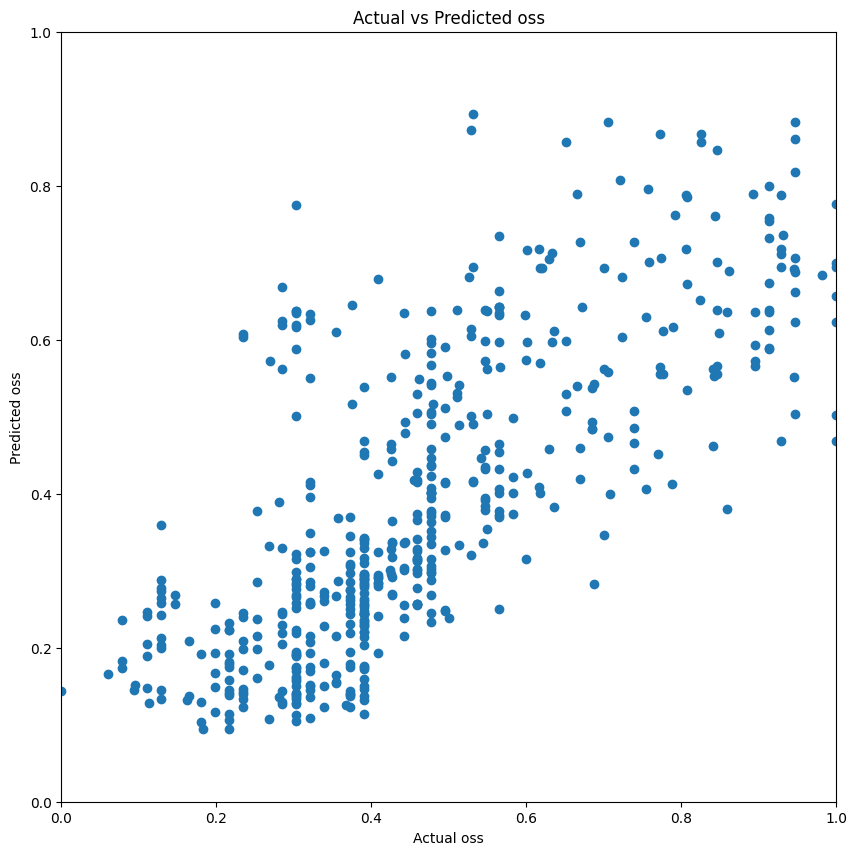

In [15]:
oss_preds = model_oss.predict(X_test_oss)
plt.figure(figsize=(10, 10))  # Make the figure square
plt.scatter(y_test_oss, oss_preds)
plt.xlabel('Actual oss')
plt.ylabel('Predicted oss')
plt.title('Actual vs Predicted oss')
plt.axis([0, 1, 0, 1])  # Set the range of both axes to be [0, 1]
plt.show()

In [ ]:
sleepiness_preds = model_sleepiness.predict(X_test_sleepiness)
plt.figure(figsize=(10, 10))  # Make the figure square
plt.scatter(y_test_sleepiness, sleepiness_preds)
plt.xlabel('Actual Sleepiness')
plt.ylabel('Predicted Sleepiness')
plt.title('Actual vs Predicted Sleepiness')
plt.axis([0, 1, 0, 1])  # Set the range of both axes to be [0, 1]
plt.show()